In [107]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as ns
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [108]:
#df = pd.read_csv("housing.csv")
#df = pd.read_csv("concreteData.csv")
df = pd.read_csv("yachtData.csv")

In [109]:
df.describe()

,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
count,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000
mean,-2.382085,0.564124,4.788664,3.936645,3.206938,0.288029,10.529186
std,1.515682,0.023327,0.253470,0.549080,0.248394,0.100678,15.173594
min,-5.000000,0.530000,4.340000,2.810000,2.730000,0.125000,0.010000
25%,-2.400000,0.546000,4.770000,3.750000,3.150000,0.200000,0.780000
50%,-2.300000,0.565000,4.780000,3.950000,3.150000,0.300000,3.090000
75%,-2.300000,0.574000,5.100000,4.170000,3.510000,0.375000,12.830000
max,0.000000,0.600000,5.140000,5.350000,3.640000,0.450000,62.420000


In [115]:
class LinearRegression:
    def __init__(self, X, y, learningRate, tolerance, maxIteration, gd=False, gd_stochastic=False, reg_param_lambda=0,err_method='sse') -> None:
        self.X = X
        self.y = y
        self.tolerance = tolerance
        self.learningRate = learningRate
        self.maxIteration = maxIteration
        self.gd = gd
        self.gd_stochastic = gd_stochastic
        self.reg_param_lambda=reg_param_lambda
        self.err_method=err_method

    def trainTestSplit(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y,
                                                          test_size = 0.3, random_state =0)

        return X_train, X_test, y_train, y_test

    def add_X0(self,X):       
        return np.column_stack([np.ones([X.shape[0],1]), X])


    def normalize(self,X):
        mean = np.mean(X,0)
        sd = np.std(X,0)
        X_norm = (X-mean)/sd


        X_norm = self.add_X0(X_norm)
        return X_norm, mean, sd


    def normalizeTestData(self, X, trainMean, trainSd):
        X_norm = (X- trainMean)/trainSd
        X_norm = self.add_X0(X_norm)
        return X_norm

    def rank(self, X, eps = 1e-12):
        u, s, vh = np.lialg.svd(X)
        return len([X for X in s if abs(X) > eps])

    

    def checkMatrix(self, X):
        X_rank = np.linalg.matrix_rank(X)
        if X_rank == min (X.shape[0], X.shape[1]):
            self.fullRank = True
            print('Data is full rank')
        else:
            self.fullRank = False
            print('data is not full rank')
    def checkInvertibility(self,X):
        if X.shape[0] < X.shape[1]:
            self.lowRank = True
            print('Data is low rank')
        else:
            self.lowRank = False
            print('Data is not low rank')

    def closedFromSolution(self, X, y):
        w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        w+= self.reg_param_lambda*math.sqrt(np.sum(w*w))
        return w

    def gradiantDescent(self, X, y):
        errorSequences = []
        last = float('inf')
        for t in tqdm(range(self.maxIteration)):
            self.w = self.w - (self.learningRate * self.costDerivative(X,y)) + self.reg_param_lambda*math.sqrt(np.sum(self.w*self.w))
            if(self.err_method=='sse'):
                cur = self.sse(X,y)
            elif(self.err_method=='rmse'):
                cur = self.rmse(X,y)
            diff = last - cur
            last = cur
        
            errorSequences.append(cur)
        
            if diff < self.tolerance and diff>0:
                print('the model stopped; no further improvement')
                print('final error: '+str(errorSequences[-1]))
                plt.plot(errorSequences)
                plt.show()
                #print(self.w)
                break
            if(t==self.maxIteration-1):
                print('final error: '+str(errorSequences[-1]))
                plt.plot(errorSequences)
                plt.show()
                
                
                
    def stochasticGradiantDescent(self, X, y):
        XX=X.copy()
        yy=y.copy()
        errorSequences = []
        last = float('inf')
        rlst=[]
        
        for i in range(0,len(yy)):
            rlst+=[i]
        
        for t in tqdm(range(self.maxIteration)):
            r=random.choice(rlst)
            X=np.array([XX[r]])
            y=np.array([yy[r]])
           
            
            self.w = self.w - (self.learningRate * self.costDerivative(X,y))+ self.reg_param_lambda*math.sqrt(np.sum(self.w*self.w))
            if(self.err_method=='sse'):
                cur = self.sse(XX,yy)
            elif(self.err_method=='rmse'):
                cur = self.rmse(XX,yy)
            diff = last - cur
            last = cur
        
            errorSequences.append(cur)
        
            if diff < self.tolerance and diff>0:
                print('the model stopped; no further improvement')
                print('final error: '+str(errorSequences[-1]))
                plt.plot(errorSequences)
                plt.show()
                #print(self.w)
                break
            if(t==self.maxIteration-1):
                print('final error: '+str(errorSequences[-1]))
                plt.plot(errorSequences)
                plt.show()
                
            
    def sse(self, X, y):
        y_hat=self.predict(X)
        return ((y_hat-y)**2).sum()
    
    def rmse(self, X, y):
        y_hat=self.predict(X)
        return np.sqrt(((y_hat-y)**2).mean())
            

    def predict(self, X):
        return X.dot(self.w)

    def costFunction(self, X, y):
        return self.sse(X, y)/2

    def costDerivative(self,X,y):
        y_hat = self.predict(X)
        return(y_hat - y).dot(X)
    
    def fit(self):
        self.X_train, self.X_test, self.y_train, self.y_test= self.trainTestSplit()
    
        self.X_train, self.mean, self.sd = self.normalize(self.X_train)
        self.X_test = self.normalizeTestData(self.X_test, self.mean, self.sd)
    
        self.checkMatrix(self.X_train)
        self.checkInvertibility(self.X_train)
    
        if self.fullRank and not self.lowRank and not self.gd:
            print('Solving using closed form solution')
            self.w=self.closedFromSolution(self.X_train, self.y_train)
            print(self.w)
        elif(self.gd_stochastic==False):
            print('solving using gradient descent')
            self.w = np.ones(self.X_train.shape[1], dtype = np.float64) * 0
            #print(self.X_train)
            self.gradiantDescent(self.X_train, self.y_train)
            #self.stochasticGradiantDescent(self.X_train, self.y_train)
            print(self.w)
        else:
            print('solving using stochastic gradient descent')
            self.w = np.ones(self.X_train.shape[1], dtype = np.float64) * 0
            #print(self.X_train)
            self.stochasticGradiantDescent(self.X_train, self.y_train)
            print(self.w)










In [118]:
regression = LinearRegression(df.values[:, 0:-1], df.values[:, -1],
                              learningRate = 0.000001,
                              tolerance = 0.0000001, 
                              maxIteration = 500000,
                              gd=True,
                              gd_stochastic=True,
                              reg_param_lambda=0.0000001,
                              err_method='rmse'                      
                        )

  0%|          | 0/500000 [00:00<?, ?it/s]

Data is full rank
Data is not low rank
solving using stochastic gradient descent
the model stopped; no further improvement
final error: 18.993197632164517


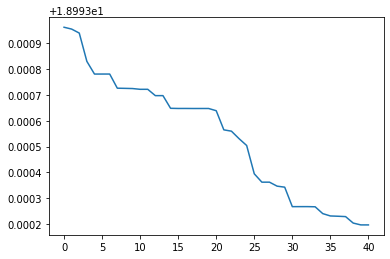

  0%|          | 0/500000 [00:00<?, ?it/s]

[ 5.37808738e-04 -3.69900197e-05 -3.04480548e-05 -1.71240121e-04
 -1.42018245e-04 -5.06875535e-05  6.70054637e-04]


In [119]:
regression.fit()

In [103]:
regression.rmse(regression.X_test,regression.y_test)

4.653026165513044

In [ ]:
the model stopped; no further improvement
final error: 10.043405884492383

[35.56425602 12.6226622   8.84461     5.68427763 -2.75484451  2.1026188
  1.40598625  1.3254541   7.35860809]